# SPECTRUM FITTING

Available on GitHub at https://github.com/spyphyz/curve_fit

The following codes approach the problem in a number of different ways. Scipy is used for continuum fitting, using a power law. Emission line fitting is performed using Gaussian (and trapezoid, if required) models in astropy. Both codes allow you to choose a range of wavelengths that you want to investigate (by changing 'lower_limit', and 'upper_limit'). You could no doubt flip this around, and perform either task using either python module, but I haven't had time to explore this further.

I've had a go at using sherpa as well - Sherpa may be better at analysing uncertainties, although I've got a bit stuck with this. Powerlaw is yet another module I've played with at the end. 

An alternative way of doing these fits may be to invoke R code... embed in the Python code

These codes import a csv file into a pandas dataframe; could utilise astropy.io to import FITS files if required - can also convert into a dataframe if required.

Future possibilities: scikit_learn to automate curve fits, using list of emission line rest wavelengths to specify each gaussian mean, sherpa to analyse continuum, pipeline to automate upload of FITS files from a relational database (e.g. SDSS), blackbody_fit of continuum?

Alternative: PySpecKit

## Scipy - Continuum Fit

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html for scipy.optimize.curve_fit details

Here I present a power law fit - can also perform polynomial fits using curve_fit.

Also see https://github.com/jeffalstott/powerlaw/blob/master/manuscript/Manuscript_Code.ipynb and https://arxiv.org/abs/1305.0215 for an alternative python powerlaw module, that could possibly automate the wavelength ranges fitted.

In [ ]:
%matplotlib inline
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [ ]:
# Input data into a pandas dataframe
path = 'Dropbox/OpenUniversity/S382_Astrophysics/SDSS_Project/sdss_abell/extra_stuff/curve_fits'
file = 'spectrum_z03_z18_auto_model.csv'
df1 = pd.read_csv(os.path.join(path, file))
df1.head(2)

In [ ]:
# choose the range of wavelength you want to apply the continuum fit to
lower_limit = 1320
upper_limit = 6000
df2 = df1[(df1['wavelength'] >= lower_limit) & (df1['wavelength'] <= upper_limit)]

# plot this section of spectrum (spectral flux density is in arbitrary units)
df2.plot(x='wavelength', y='flux', lw=0.4, color='green', label='data')
plt.title('Continuum Section', fontsize=24, color='black')
plt.xlabel(r'Emitted Wavelength / $\AA$',  fontsize=13)
plt.ylabel('Spectral Flux Density / AU', fontsize=11)

In [ ]:
xData = df2['wavelength']
yData = df2['flux']

def f(x, N, a):
    return N * x ** a

# optimize
popt, pcov = curve_fit(f, xData, yData)

# the output here are the values for k and a, respectively, where y = kx^a
popt[0], popt[1]

In [ ]:
# 1SD of the parameters in popt, calculated from the covariance pcov array
perr = np.sqrt(np.diag(pcov))
perr

In [ ]:
# plot data with power model
plt.plot(xData, yData, 'g', label='data') # original spectrum data in green
plt.plot(xData, popt[0]*xData**popt[1], 'r', label='power model') # power model data in red

# plot standard deviation curves, based on perr
plt.plot(xData, (popt[0]+perr[1])*xData**(popt[1]+perr[1]), '-', lw=0.2, color='purple', label='+1SD')
plt.plot(xData, (popt[0]-perr[1])*xData**(popt[1]-perr[1]), '-', lw=0.2, color='purple', label='- 1SD')

plt.title('Continuum Fit', fontsize=24, color='black')
plt.xlabel(r'Emitted Wavelength / $\AA$',  fontsize=13)
plt.ylabel('Spectral Flux Density / AU')
plt.legend()
plt.savefig(os.path.join(path, 'spectrum_continuum.png'), dpi = 1080)

## Astropy - Emission Line Fit

See http://docs.astropy.org/en/stable/modeling/index.html for astropy model details
This code works by inputting a csv file of data which has already had the baseline continuum model subtracted. You could also perform this subtraction easily within the pandas dataframe if so desired, and even input the power law model automatically from the Scipy code above if you were really clever. 

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import os
from astropy.modeling import models, fitting
from astropy.modeling.models import Gaussian1D

In [ ]:
# Using the Levenberg-Marquardt algorithm and least squares statistic - LevMarLSQFitter()
# Fitting Gaussian and Trapezoid models to a curve

In [ ]:
# Input data into a pandas dataframe
path = 'Dropbox/OpenUniversity/S382_Astrophysics/SDSS_Project/sdss_abell/extra_stuff/curve_fits'
file = 'spectrum_z03_z18_auto_model.csv'
df1 = pd.read_csv(os.path.join(path, file))
df1.head(3)

In [ ]:
lower_limit = 4800
upper_limit = 4950
df2 = df1[(df1['wavelength'] >= lower_limit) & (df1['wavelength'] <= upper_limit)]

In [ ]:
df2.plot(x='wavelength', y='flux_minus_top_minus15', lw=0.6, color='blue', label='data') #lw = line width
plt.title('Emission Peak Isolated', fontsize=14, color='black')
plt.legend()
# plt.grid(True)
plt.xlabel(r'Emitted Wavelength / $\AA$',  fontsize=13)
plt.ylabel('Continuum-Subtracted Spectral Flux Density / AU', fontsize=9)

In [ ]:
x = df2['wavelength']
y = df2['flux_minus_top_minus15']

In [ ]:
# Fit the data using a box model
# Insert best guesses for model parameters
#t_init = models.Trapezoid1D(amplitude=58, x_0=2797., width=200, slope=0.5)
#fit_t = fitting.LevMarLSQFitter()
#t = fit_t(t_init, x, y)

# Fit the data using a Gaussian
# set mean as the rest emission wavelength for species (e.g. Mg II)
g_init = models.Gaussian1D(amplitude=40, mean=4861, stddev=25)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)

# this prints the model output parameters after fitting
print(g)
#Prints FWHM (units are Angstroms)...
g.fwhm

In [ ]:
# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, '.', label='data points')
plt.plot(x, g(x), label='gaussian fit', color='red')

plt.axvline(x=g.mean.value, label='mean', color='yellow', lw=0.5)
plt.vlines(x=g.mean.value+0.5*g.fwhm, ymin=0, ymax=g(g.mean.value+0.5*g.fwhm), label='fwhm', color='purple', lw=0.5)
plt.vlines(x=g.mean.value-0.5*g.fwhm, ymin=0, ymax=g(g.mean.value-0.5*g.fwhm), color='purple', lw=0.5)

#plt.plot(x, t(x), label='Trapezoid')

plt.title('Emission Peak Gaussian-Fitted (Astropy)', fontsize=14, color='black')
plt.xlabel(r'Emitted Wavelength / $\AA$',  fontsize=13)
plt.ylabel('Continuum-Subtracted Spectral Flux Density / AU')
plt.ylim(0,)
plt.legend()
plt.savefig(os.path.join(path, 'species_curve_fit.png'), dpi = 1080)

In [ ]:
# this prints the model output parameters after fitting
# print(t)

## Sherpa Fits

Install sherpa and saba as per instructions: https://github.com/astropy/saba/blob/d729b34262f70d0679cdcb112ab2832b73791098/docs/index.rst#id17

Further install details: https://github.com/sherpa/sherpa/

Documentation: http://cxc.harvard.edu/sherpa4.10/, http://conference.scipy.org/proceedings/SciPy2009/paper_8/full_text.pdf, http://conference.scipy.org/proceedings/scipy2011/pdfs/brefsdal.pdf, http://adsabs.harvard.edu/abs/2007ASPC..376..543D, http://cxc.cfa.harvard.edu/contrib/sherpa/, and https://saba.readthedocs.io/en/latest/

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import os
from astropy.modeling.fitting import SherpaFitter
from astropy.modeling.models import Gaussian1D

In [ ]:
# Input data into a pandas dataframe
path = 'Dropbox/OpenUniversity/S382_Astrophysics/SDSS_Project/sdss_abell/extra_stuff/curve_fits'
file = 'spectrum_z03_z18_auto_model.csv'
df1 = pd.read_csv(os.path.join(path, file))
df1.head(2)

In [ ]:
lower_limit = 4800
upper_limit = 4950
df2 = df1[(df1['wavelength'] >= lower_limit) & (df1['wavelength'] <= upper_limit)]

df2.plot(x='wavelength', y='flux_minus_top_minus15', lw=0.6, color='blue', label='data') #lw = line width
plt.title('Emission Peak Isolated', fontsize=14, color='black')
plt.legend()
# plt.grid(True)
plt.xlabel(r'Emitted Wavelength / $\AA$',  fontsize=13)
plt.ylabel('Continuum-Subtracted Spectral Flux Density / AU', fontsize=9)

In [ ]:
#sfit = SherpaFitter(optimizer='levmar', estmethod='confidence') # defaults to statistic='leastsq', I think!
sfit = SherpaFitter(statistic='chi2', optimizer='levmar', estmethod='confidence') # use if have error data

In [ ]:
true = Gaussian1D(amplitude=30, mean=4860, stddev=5, name='Mg II')
err = 0.8
step = 0.2
x = df2['wavelength']
y = df2['flux_minus_top_minus15']
y_errs = df2['error']
binsize = step * np.ones(x.shape) # binsize is the width of the bin!

In [ ]:
fit_model = true.copy() # offset fit model from true
fit_model.amplitude = 30
fit_model.mean = 4860
fit_model.stddev = 5

In [ ]:
# fitted_model = sfit(fit_model, x, y)
fitted_model = sfit(fit_model, x, y, xbinsize=binsize, err=y_errs) # if error data available

In [ ]:
fitted_model

In [ ]:
fitted_model.fwhm

In [ ]:
fitted_model.mean.value

In [ ]:
# Plot the data with the best-fit model
# plt.figure(figsize=(8,5))
plt.plot(x, y, '.', label='data points')
#plt.plot(x, t(x), label='Trapezoid')
plt.plot(x, fitted_model(x), label='gaussian fit', color='red')
plt.axvline(x=fitted_model.mean.value, label='mean', color='yellow', lw=0.5)
plt.vlines(x=fitted_model.mean.value+0.5*fitted_model.fwhm, ymin=0, ymax=fitted_model(fitted_model.mean.value+0.5*fitted_model.fwhm), label='fwhm', color='purple', lw=0.5)
plt.vlines(x=fitted_model.mean.value-0.5*fitted_model.fwhm, ymin=0, ymax=fitted_model(fitted_model.mean.value-0.5*fitted_model.fwhm), color='purple', lw=0.5)

plt.title('Emission Peak Gaussian-Fitted (Sherpa)', fontsize=14, color='black')
plt.xlabel(r'Emitted Wavelength / $\AA$',  fontsize=13)
plt.ylabel('Continuum-Subtracted Spectral Flux Density / AU')
plt.ylim(0,)
plt.legend()

In [ ]:
print(sfit.fit_info)

In [ ]:
# use this if statistic='chi2'
param_errors = sfit.est_errors(sigma=3)  # Note that sigma can be an input

In [ ]:
min_model = fitted_model.copy()
max_model = fitted_model.copy()

for pname, pval, pmin, pmax in zip(*param_errors):
        print(pname, pval, pmin, pmax)
        getattr(min_model, pname).value = pval + pmin
        getattr(max_model, pname).value = pval + pmax

In [ ]:
fitted_model = sfit(fit_model, x, y, xbinsize=binwidth, err=yerrs)
plt.plot(x, true(x), label="True")
plt.errorbar(x, y, xerr=binwidth, yerr=yerrs, ls="", label="Data")
plt.plot(x, fit_model(x), label="Starting fit model")
plt.plot(x, fitted_model(x), label="Fitted model")
plt.legend(loc=2, frameon=False)
plt.xlim((-3, 3))

# Powerlaw

http://pythonhosted.org/powerlaw/; https://pypi.org/project/powerlaw/; http://arxiv.org/abs/1305.0215; http://arxiv.org/abs/0706.1062; http://www.plosone.org/article/info%3Adoi%2F10.1371%2Fjournal.pone.0019779; http://www.plosone.org/article/info%3Adoi%2F10.1371%2Fjournal.pone.0085777

I don't yet understand how this works! This example code http://nbviewer.jupyter.org/github/jeffalstott/powerlaw/blob/master/manuscript/Manuscript_Code.ipynb will probably be the most useful to understand how to use powerlaw

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import mpmath
import scipy
from pandas import DataFrame
import matplotlib.pyplot as plt
import os
import powerlaw

In [3]:
# Input data into a pandas dataframe
path = 'Dropbox/OpenUniversity/S382_Astrophysics/SDSS_Project/sdss_abell/extra_stuff/curve_fits'
file = 'spectrum_z03_z18_auto_model.csv'
df1 = pd.read_csv(os.path.join(path, file))
df1.head(2)

,wavelength,flux,model_top,model_middle,model_bottom,flux_minus_top,flux_minus_middle,flux_minus_bottom,Unnamed: 8,flux_minus_middle_minus20,flux_minus_top_minus15,Unnamed: 11,scatter,error
0,1279,439.459226,452.737237,360.165597,393.085315,-13.278011,79.293629,46.373911,NaN,59.293629,-28.278011,NaN,0.000000,70.662066
1,1280,436.743732,452.094768,359.708749,392.566460,-15.351036,77.034983,44.177272,NaN,57.034983,-30.351036,NaN,47.443813,26.924685


Text(0,0.5,'Spectral Flux Density / AU')

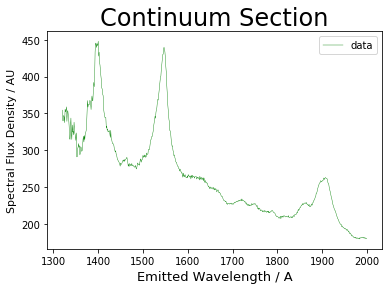

In [4]:
# choose the range of wavelength you want to apply the continuum fit to
lower_limit = 1320
upper_limit = 2000
df2 = df1[(df1['wavelength'] >= lower_limit) & (df1['wavelength'] <= upper_limit)]

# plot this section of spectrum (spectral flux density is in arbitrary units)
df2.plot(x='wavelength', y='flux', lw=0.4, color='green', label='data')
plt.title('Continuum Section', fontsize=24, color='black')
plt.xlabel(r'Emitted Wavelength / $\AA$',  fontsize=13)
plt.ylabel('Spectral Flux Density / AU', fontsize=11)

In [45]:
data = df2['flux'] # data can be list or numpy array
results = powerlaw.Fit(data)
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'lognormal')

10.004763828889386
341.6921325


Calculating best minimal value for power law fit
/Users/spydoc/anaconda3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


AttributeError: 'Power_Law' object has no attribute 'fwhm'

In [12]:
R, p = results.distribution_compare('power_law', 'lognormal_positive')

/Users/spydoc/anaconda3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


/Users/spydoc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,'Continuum-Subtracted Spectral Flux Density / AU')

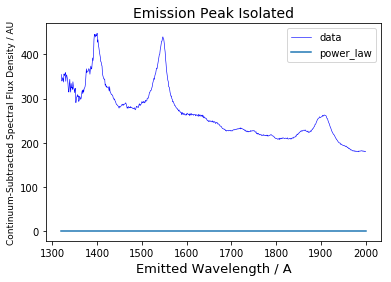

In [42]:
x = df2['wavelength']
y = df2['flux']
df2['power_law']=results.power_law.xmin*df2['wavelength']**-results.power_law.alpha #don't understand this yet!!!

ax1 = df2.plot(x='wavelength', y='flux', lw=0.6, color='blue', label='data') #lw = line width
ax2 = df2.plot(x='wavelength', y='power_law', ax = ax1) # need to sort this line out to plot the power law

plt.title('Emission Peak Isolated', fontsize=14, color='black')
plt.legend()
# plt.grid(True)
plt.xlabel(r'Emitted Wavelength / $\AA$',  fontsize=13)
plt.ylabel('Continuum-Subtracted Spectral Flux Density / AU', fontsize=9)

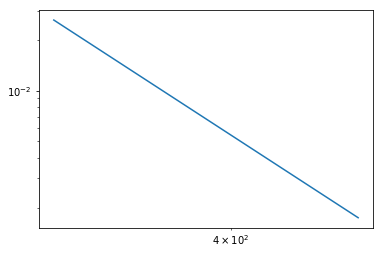

In [46]:
results.power_law.plot_pdf()

/Users/spydoc/anaconda3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


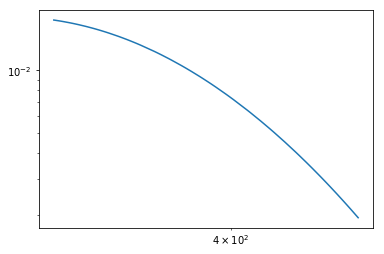

In [47]:
results.lognormal.plot_pdf()

In [51]:
data = results.power_law.pdf()
data

array([0.02635344, 0.0262603 , 0.02537895, 0.02511155, 0.02483484,
       0.02458653, 0.02440501, 0.0243238 , 0.02430808, 0.0230606 ,
       0.02238054, 0.02177727, 0.02168375, 0.02107941, 0.01989357,
       0.01989299, 0.01971427, 0.0196932 , 0.01950856, 0.01855506,
       0.01835032, 0.01825732, 0.01790047, 0.01777926, 0.01759807,
       0.01734712, 0.01719076, 0.01663351, 0.01628375, 0.01611148,
       0.01487539, 0.01481416, 0.0145378 , 0.01385655, 0.01372415,
       0.01356035, 0.01285786, 0.0128328 , 0.01283207, 0.01274241,
       0.01273189, 0.01272608, 0.01253422, 0.01219832, 0.01077891,
       0.01065679, 0.01048903, 0.01011832, 0.0094737 , 0.00925592,
       0.00850459, 0.00839685, 0.00811586, 0.00773146, 0.00721446,
       0.00703152, 0.00664786, 0.00645894, 0.00622641, 0.0056955 ,
       0.00551441, 0.00534521, 0.00532077, 0.00470704, 0.00458376,
       0.00416945, 0.0038577 , 0.00372448, 0.00369494, 0.00336712,
       0.00305175, 0.00296422, 0.00278063, 0.0026467 , 0.00262

# Pyspeckit

PySpecKit at http://pyspeckit.readthedocs.io/en/latest/index.html; https://github.com/pyspeckit/pyspeckit; https://keflavich.github.io/pyspeckit-paper/main_compressed.pdf

In [60]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from pandas import DataFrame
import matplotlib.pyplot as plt # don't necessarily need this as sp.plotter works
import os

from astropy import units as u
import pyspeckit

In [84]:
# Input data into a pandas dataframe
path = 'Dropbox/OpenUniversity/S382_Astrophysics/SDSS_Project/sdss_abell/extra_stuff/curve_fits'
file = 'spectrum_z03_z18_auto_model.csv'
df1 = pd.read_csv(os.path.join(path, file))
df2.head(2)

,wavelength,flux,model_top,model_middle,model_bottom,flux_minus_top,flux_minus_middle,flux_minus_bottom,Unnamed: 8,flux_minus_middle_minus20,flux_minus_top_minus15,Unnamed: 11,scatter,error
41,1320,354.460157,427.510871,342.174725,372.673143,-73.050714,12.285431,-18.212987,NaN,-7.714569,-88.050714,NaN,21.064325,7.191131
42,1321,339.805102,426.923023,341.754165,372.196494,-87.117921,-1.949063,-32.391393,NaN,-21.949063,-102.117921,NaN,24.862741,6.889723


Text(0,0.5,'Spectral Flux Density / AU')

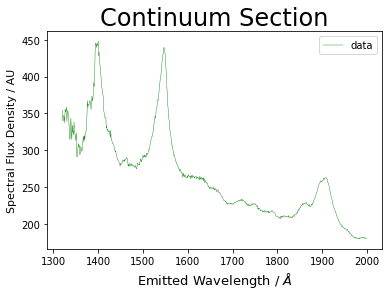

In [78]:
# choose the range of wavelength you want to apply the continuum fit to
lower_limit = 1320
upper_limit = 2000
df2 = df1[(df1['wavelength'] >= lower_limit) & (df1['wavelength'] <= upper_limit)]

# plot this section of spectrum (spectral flux density is in arbitrary units)
df2.plot(x='wavelength', y='flux', lw=0.4, color='green', label='data')
plt.title('Continuum Section', fontsize=24, color='black')
plt.xlabel(r'Emitted Wavelength / $\AA$',  fontsize=13)
plt.ylabel('Spectral Flux Density / AU', fontsize=11)

The truth value of a Quantity is ambiguous. In the future this will raise a ValueError.


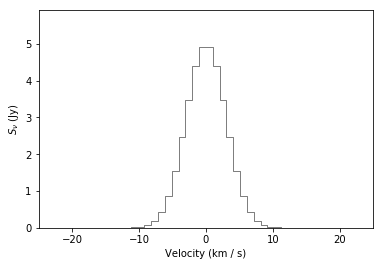

In [79]:
#xaxis = df2['wavelength'] #*u.km/u.s 

xaxis = np.linspace(-25, 25)*u.km/u.s
sigma = 3.0*u.km/u.s
data = 5*np.exp(-xaxis**2 / (2*sigma**2))*u.Jy
error = np.ones_like(data) * 0.2
sp = pyspeckit.Spectrum(xarr=xaxis, data=data, error=error)
sp.plotter()
#sp.plotter(errstyle='fill') # fill doesn't work. The errors should be shown with the ‘fill’ style and represent symmetric 1 − SD Gaussian errors
#sp.plotter.savefig("example_fig_1.pdf")

In [86]:
# the follwoing code from the pyspeckit website is for fitting an sdss seyfert spectrum

import pyspeckit
import numpy as np

# Rest wavelengths of the lines we are fitting - use as initial guesses
NIIa = 6549.86
NIIb = 6585.27
Halpha = 6564.614
SIIa = 6718.29
SIIb = 6732.68

In [88]:
# Initialize spectrum object and plot region surrounding Halpha-[NII] complex
# spec = pyspeckit.Spectrum('sample_sdss.txt', errorcol=2)
xaxis = df2['wavelength']
data = df2['flux']
error = df2['error']
spec = pyspeckit.Spectrum(xarr = xaxis, data = data, error = error)
spec.plotter(xmin = 1320, xmax = 2000, ymin = 0, ymax = 150)

evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead


TypeError: unsupported operand type(s) for +: 'method' and 'bool'

In [ ]:
# Initialize spectrum object and plot region surrounding Halpha-[NII] complex
spec = pyspeckit.Spectrum('sample_sdss.txt', errorcol=2)
spec.plotter(xmin = 6450, xmax = 6775, ymin = 0, ymax = 150)

# We fit the [NII] and [SII] doublets, and allow two components for Halpha.
# The widths of all narrow lines are tied to the widths of [SII].
guesses = [50, NIIa, 5, 100, Halpha, 5, 50, Halpha, 50, 50, NIIb, 5, 20, SIIa, 5, 20, SIIb, 5]
tied = ['', '', 'p[17]', '', '', 'p[17]', '', 'p[4]', '', '3 * p[0]', '', 'p[17]', '', '', 'p[17]', '', '', '']

# Actually do the fit.
spec.specfit(guesses = guesses, tied = tied, annotate = False)
spec.plotter.refresh()

# Let's use the measurements class to derive information about the emission
# lines.  The galaxy's redshift and the flux normalization of the spectrum
# must be supplied to convert measured fluxes to line luminosities.  If the
# spectrum we loaded in FITS format, 'BUNITS' would be read and we would not
# need to supply 'fluxnorm'.
spec.measure(z = 0.05, fluxnorm = 1e-17)

# Now overplot positions of lines and annotate

y = spec.plotter.ymax * 0.85    # Location of annotations in y

for i, line in enumerate(spec.measurements.lines.keys()):

    # If this line is not in our database of lines, don't try to annotate it
    if line not in spec.speclines.optical.lines.keys(): continue

    x = spec.measurements.lines[line]['modelpars'][1]   # Location of the emission line
    spec.plotter.axis.plot([x]*2, [spec.plotter.ymin, spec.plotter.ymax], ls = '--', color = 'k')   # Draw dashed line to mark its position
    spec.plotter.axis.annotate(spec.speclines.optical.lines[line][-1], (x, y), rotation = 90, ha = 'right', va = 'center')  # Label it

# Make some nice axis labels
spec.plotter.axis.set_xlabel(r'Wavelength / $\AA$')
spec.plotter.axis.set_ylabel(r'Flux $(10^{-17} \mathrm{erg/s/cm^2/\AA})$')
spec.plotter.refresh()

# Print out spectral line information
print "Line   Flux (erg/s/cm^2)     Amplitude (erg/s/cm^2)    FWHM (Angstrom)   Luminosity (erg/s)"
for line in spec.measurements.lines.keys():
    print line, spec.measurements.lines[line]['flux'], spec.measurements.lines[line]['amp'], spec.measurements.lines[line]['fwhm'], \
        spec.measurements.lines[line]['lum']

# Had we not supplied the objects redshift (or distance), the line
# luminosities would not have been measured, but integrated fluxes would
# still be derived.  Also, the measurements class separates the broad and
# narrow H-alpha components, and identifies which lines are which. How nice!

spec.specfit.plot_fit()

# Save the figure
# spec.plotter.figure.savefig("sdss_fit_example.png")

In [97]:
df2['wavelength']

AttributeError: 'Series' object has no attribute 'df2'